In [4]:
%matplotlib inline

In [2]:
import logbook
import hyperseti
import numpy as np
from astropy import units as u
import pylab as plt
import cupy as cp
from hyperseti.kurtosis import spectral_kurtosis, sk_flag

hyperseti.logger_group.level = logbook.DEBUG
hyperseti.data_array.logger.level  = logbook.DEBUG

bshuf filter already loaded, skip it.


[2021-04-24 13:58:20.407168] INFO: hyperseti.utils: <spectral_kurtosis> Converting arg 0 to cupy..
[2021-04-24 13:58:20.408142] DEBUG: hyperseti.utils: <spectral_kurtosis> Return space requested: cpu
[2021-04-24 13:58:20.409342] DEBUG: hyperseti.kurtosis: rescaling SK by 2
[2021-04-24 13:58:20.411028] INFO: hyperseti.utils: <spectral_kurtosis> Converting output to numpy
float32 float32
float32 float32
(512,) (512,)


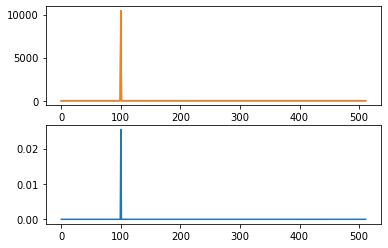

In [5]:
import numpy as np
from astropy import units as u

def sk_cpu(x, N=1):
    x_sum = x.sum(axis=0)
    x2_sum = (x**2).sum(axis=0)
    n = x.shape[0]
    return (N*n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1).squeeze()

# zero drift test, no normalization
noise = np.random.random(size=32*1*512).reshape((32,1,512)) * 2
test_data = np.zeros(shape=(32, 1, 512), dtype='float32')
test_data[:, 0, 255] = 100
test_data[:, 0, 100] = 100*np.sin(4*np.arange(0,32))
test_data += noise**2


metadata = {'fch1': 1000*u.MHz, 
        'dt': 1.0*u.s, 
        'df': 1.0*u.Hz}

test_data_gpu = cp.asarray(test_data.squeeze())

skg = spectral_kurtosis(test_data, metadata, return_space='cpu')

skc = sk_cpu(test_data.squeeze(), N=2)
#skg = cp.asnumpy(sk_gpu(test_data_gpu, N=2))

print(test_data.dtype, test_data_gpu.dtype)
print(skc.dtype, skg.dtype)

print(skg.shape, skc.shape)

plt.subplot(2,1,1)
plt.plot(skg)
plt.plot(skc)
plt.subplot(2,1,2)
plt.plot(skg - skc)


[2021-04-24 13:58:26.048928] INFO: hyperseti.utils: <dedoppler> Converting arg 0 to cupy..
[2021-04-24 13:58:26.049847] DEBUG: hyperseti.utils: <dedoppler> Return space requested: cpu
[2021-04-24 13:58:26.052138] INFO: hyperseti.hyperseti: Dedopp setup time: 1.80ms
[2021-04-24 13:58:26.052607] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1, 65), (512,))
[2021-04-24 13:58:26.053482] DEBUG: hyperseti.hyperseti: rescaling SK by 2
[2021-04-24 13:58:26.054204] DEBUG: hyperseti.hyperseti: driftrates: [-32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32]
[2021-04-24 13:58:26.057682] INFO: hyperseti.hyperseti: Dedopp kernel time: 5.11ms
[2021-04-24 13:58:26.058242] INFO: hyperseti.utils: <dedoppler> Converting output 0 to numpy


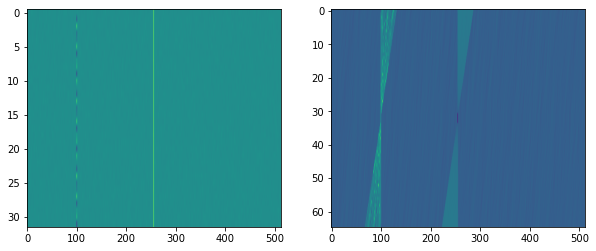

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(test_data.squeeze(), aspect='auto')

dedopp, metadata = hyperseti.dedoppler(test_data, metadata, boxcar_size=1, kernel='kurtosis',
                             max_dd=1.0, return_space='cpu')
plt.subplot(1,2,2)
plt.imshow(np.log(dedopp), aspect='auto')

### real data

In [7]:
from hyperseti.data_array import from_h5
d_h5 = from_h5('/home/dancpr/blimpy/tests/test_data/Voyager1.single_coarse.fine_res.h5')

[2021-04-24 13:58:33.522555] INFO: hyperseti.utils: <spectral_kurtosis> Converting arg 0 to cupy..
[2021-04-24 13:58:33.525470] DEBUG: hyperseti.utils: <spectral_kurtosis> Return space requested: cpu
[2021-04-24 13:58:33.526422] DEBUG: hyperseti.kurtosis: rescaling SK by 102
[2021-04-24 13:58:33.527657] INFO: hyperseti.utils: <spectral_kurtosis> Converting output to numpy
MEAN 1.094 STD 0.4016851484775543
MEAN 1.161 STD 0.4265289604663849


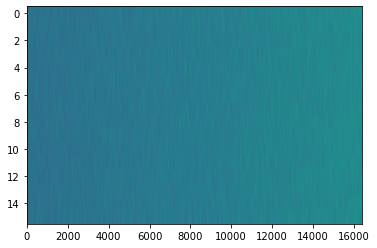

In [8]:
d = d_h5.data[:]

metadata = {}
metadata['df'] = np.abs(d_h5.frequency.val_step * u.MHz)
metadata['dt'] = np.abs(d_h5.time.val_step * u.s)
metadata['fch1'] = d_h5.frequency.val_start * u.MHz

D = d[:, :, 16384:16384+16384]
plt.imshow(D.squeeze(), aspect='auto')

sk = spectral_kurtosis(D, metadata, return_space='cpu')

def sk_cpu(x, N=1):
    x_sum = x.sum(axis=0)
    x2_sum = (x**2).sum(axis=0)
    n = x.shape[0]
    return N*(n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1)

skc = sk_cpu(D.squeeze(), N=102)

print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")
print(f"MEAN {np.mean(skc):2.3f} STD {np.std(skc)}")

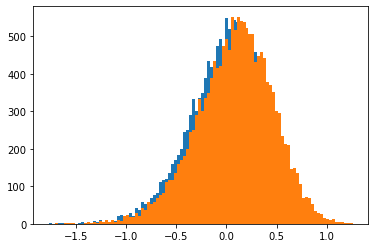

In [9]:
z = plt.hist(np.log(sk), bins=100)
z = plt.hist(np.log(skc), bins=100)

In [11]:
mask = sk_flag(d, metadata, n_sigma_lower=2, n_sigma_upper=5, flag_upper=True, flag_lower=True, 
               return_space='cpu')
dma = np.ma.array(d.mean(axis=0)).squeeze()
dma.mask = mask
n = np.ma.array(np.arange(dma.shape[0]))
n.mask = mask

[2021-04-24 13:58:51.449872] INFO: hyperseti.utils: <sk_flag> Converting arg 0 to cupy..
[2021-04-24 13:58:51.462404] DEBUG: hyperseti.utils: <sk_flag> Return space requested: cpu
[2021-04-24 13:58:51.464140] DEBUG: hyperseti.kurtosis: rescaling SK by 102
[2021-04-24 13:58:51.465795] INFO: hyperseti.utils: <sk_flag> Converting output to numpy


In [12]:
d_gpu = cp.asarray(d)
mask_gpu = cp.repeat(cp.asarray(mask), d_gpu.shape[0]).reshape(d_gpu.shape)
cp.putmask(d_gpu, mask_gpu, 0)

In [15]:
mask = sk_flag(d, metadata, n_sigma_lower=2, n_sigma_upper=5, flag_upper=True, flag_lower=True)
d = d_h5.data[:].astype('float32')

d_gpu = cp.asarray(d)
d_norm = hyperseti.normalize(d_gpu)

mask_gpu = cp.repeat(cp.asarray(mask), d_gpu.shape[0]).reshape(d_gpu.shape)
print(f"")
cp.putmask(d_gpu, mask_gpu, 0)

d_norm_masked = hyperseti.normalize(d_gpu)

pad = 50000
print(f"{d_norm[..., pad:-pad].std()}, {d_norm_masked[..., pad:-pad].std()}")

[2021-04-24 13:59:23.850474] INFO: hyperseti.utils: <sk_flag> Converting arg 0 to cupy..
[2021-04-24 13:59:23.878498] DEBUG: hyperseti.kurtosis: rescaling SK by 102
[2021-04-24 13:59:25.266400] DEBUG: hyperseti.hyperseti: flag fraction correction factor: 1.0
[2021-04-24 13:59:25.272181] INFO: hyperseti.hyperseti: Normalisation time: 292.58ms

[2021-04-24 13:59:25.275462] DEBUG: hyperseti.hyperseti: flag fraction correction factor: 1.0
[2021-04-24 13:59:25.276214] INFO: hyperseti.hyperseti: Normalisation time: 1.01ms
1.0510433, 1.0510439


In [16]:
np.max(d_norm_masked)

array(1027.398, dtype=float32)

In [17]:
np.argmax(d.mean(axis=0))

524288

### Setigen data

In [3]:
import setigen as stg

metadata = {'fch1': 6095.214842353016*u.MHz, 
            'dt': 18.25361108*u.s , 
            'df': 2.7939677238464355*u.Hz}

frame = stg.Frame(fchans=2**12*u.pixel,
                  tchans=32*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

test_tones = [
  {'f_start': frame.get_frequency(index=500), 'drift_rate': 0.50*u.Hz/u.s, 'snr': 10000, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=800), 'drift_rate': -0.40*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=2048), 'drift_rate': 0.00*u.Hz/u.s, 'snr': 200, 'width': 6*u.Hz},
  {'f_start': frame.get_frequency(index=3000), 'drift_rate': 0.07*u.Hz/u.s, 'snr': 500, 'width': 3*u.Hz}
]

noise = frame.add_noise(x_mean=10, x_std=5, noise_type='chi2')

for tone in test_tones:
    signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

In [5]:
%matplotlib inline

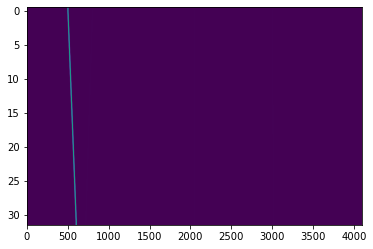

In [6]:
plt.imshow(frame.data, aspect='auto')

[2021-07-22 15:34:30.566774] DEBUG: hyperseti.utils: spectral_kurtosis on_gpu inner, args: (array([[[10.67227537, 10.749104  ,  9.61315922, ..., 11.74630303,
          9.296742  , 10.90710152]],

       [[ 8.95463894,  9.13152244, 11.3446505 , ..., 12.43169373,
         10.10618586,  8.89462481]],

       [[ 9.62809386,  9.91693399,  9.62880309, ..., 10.89446119,
         10.03933489, 10.68875493]],

       ...,

       [[10.59829455,  9.26599746,  9.81987069, ..., 10.18032697,
         10.09441294, 10.20003698]],

       [[ 9.7214975 ,  8.93158976,  8.64106754, ..., 10.01971603,
         12.08478733,  8.47298806]],

       [[ 8.17440784, 10.45458386,  9.44032737, ..., 11.01493298,
          9.06416552,  9.54892997]]]), {'fch1': <Quantity 6095.21484235 MHz>, 'dt': <Quantity 18.25361108 s>, 'df': <Quantity 2.79396772 Hz>, 'frequency_step': <Quantity 2.79396772 Hz>, 'time_step': <Quantity 18.25361108 s>})
[2021-07-22 15:34:30.568489] INFO: hyperseti.utils: <spectral_kurtosis> Converting 

/home/dancpr/hyperseti/hyperseti/utils.py:55: RuntimeWarning: <spectral_kurtosis> Arg x is not float32, could cause issues...
  warnings.warn(f"<{func_name}> Arg {argname} is not float32, could cause issues...", RuntimeWarning)


Text(0.5, 0, 'with flagging')

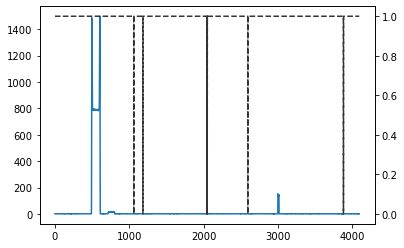

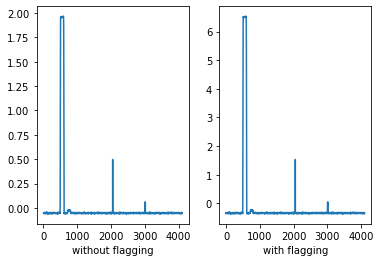

In [17]:
metadata['frequency_step'] = metadata['df']
metadata['time_step'] = metadata['dt']
sk = spectral_kurtosis(frame.data.reshape((32, 1, 4096)), metadata, return_space='cpu')
print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")


plt.plot(sk)
plt.twinx()
d = frame.data.reshape((32, 1, 4096))



d_norm = hyperseti.dedoppler.normalize(d, return_space='cpu')
import copy
metadata = copy.deepcopy(metadata)

print(type(d_norm),  "HERE")
mask = hyperseti.kurtosis.sk_flag(d_norm, metadata, n_sigma_lower=2, n_sigma_upper=5, 
                                  flag_upper=True, flag_lower=True, return_space='cpu')

d_norm_flagged = hyperseti.dedoppler.normalize(d, mask, return_space='cpu')

print(type(mask))
plt.plot(mask, ls='dashed', color='#333333')
plt.figure()
plt.subplot(1,2,1)
plt.plot(d_norm.mean(axis=0).squeeze())
plt.xlabel("without flagging")
plt.subplot(1,2,2)
plt.plot(d_norm_flagged.mean(axis=0).squeeze())
plt.xlabel("with flagging")

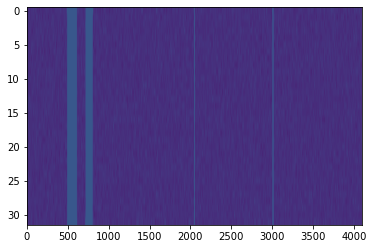

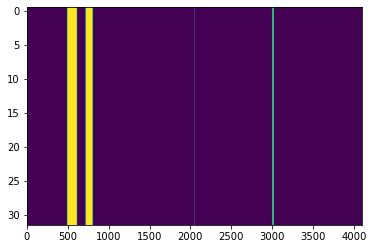

In [36]:
df = cp.asarray(d_norm)
mask_gpu = cp.repeat(cp.asarray(mask.reshape(1, 1, len(mask))), d_norm.shape[0], axis=0)
cp.putmask(df, mask_gpu, 0)
plt.figure()
plt.imshow(cp.asnumpy(df).squeeze(), aspect='auto')
plt.figure()
plt.imshow(cp.asnumpy(mask_gpu).squeeze(), aspect='auto')

In [60]:
d

array([[[11.40536709,  8.74645963, 12.50554303, ...,  9.56244724,
          8.99907949, 10.92070109]],

       [[ 9.23959438, 10.53700085,  9.43550424, ...,  9.01717954,
         10.1083339 ,  8.52935368]],

       [[10.29493457,  9.61177061, 10.48351989, ...,  9.57810645,
          9.53963261, 10.21410382]],

       ...,

       [[ 9.76704665, 10.30186253, 12.88998951, ...,  8.46226955,
         10.98929438, 11.85686657]],

       [[ 9.7085673 ,  8.98727415,  8.58121914, ...,  9.21889783,
          9.2789853 ,  9.58455703]],

       [[ 9.57271608,  9.43179278, 10.7291004 , ...,  9.11232446,
          9.9174795 , 11.34372912]]])

Unit("s")